## This Notebook explores Neuroevolution using EvoTorch library

https://docs.evotorch.ai/v0.3.0/user_guide/neuroevolution/#neuroevolution-at-scale

#### Imports


In [1]:
import torch
from evotorch.tools import dtype_of, device_of

from evotorch.neuroevolution import NEProblem

from evotorch.algorithms import PGPE
from evotorch.logging import PandasLogger

#### Method using the network to solve the problem and evaluate the result

In [2]:
def sign_prediction_score(network: torch.nn.Module):
    # Generate 32 random gaussian vectors
    samples = torch.randn((32, 3), dtype=dtype_of(network), device=device_of(network))
    # Apply the network to the gaussian vectors
    network_out = network(samples)
    # Get the sign of the single output
    sign_out = torch.sign(network_out[:, 0])
    # Get the sign of the sum of the inputs
    sign_sum = torch.sign(samples.sum(dim=-1))
    # Number of times the network was correct
    reward_gained = (sign_sum == sign_out).to(torch.float).sum()
    # Number of times the network was incorrect
    reward_lost = (sign_sum != sign_out).to(torch.float).sum()
    return (reward_gained - reward_lost) / 32

#### Creating the problem from the method

Got the following error on make:

FileNotFoundError: [Errno 2] No such file or directory

solution: conda install grpcio

In [3]:
sign_prediction_problem = NEProblem(
    # The objective sense -- we wish to maximize the sign_prediction_score
    objective_sense="max",
    # The network is a Linear layer mapping 3 inputs to 1 output
    network=torch.nn.Linear(3, 1),
    # Networks will be evaluated according to sign_prediction_score
    network_eval_func=sign_prediction_score,
)

2022-11-28 21:22:15,846	INFO worker.py:1528 -- Started a local Ray instance.


#### Optimization algorithm?/Searcher used to search

In [4]:
searcher = PGPE(
    sign_prediction_problem,
    popsize=50,
    radius_init=2.25,
    center_learning_rate=0.2,
    stdev_learning_rate=0.1,
)

#### Log and run 

In [5]:
logger = PandasLogger(searcher)
searcher.run(100)

#### Show learning curve

<AxesSubplot:xlabel='iter'>

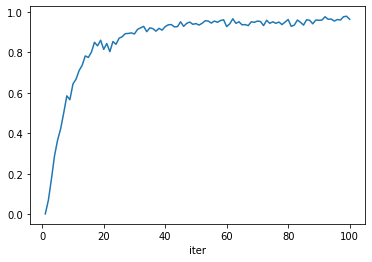

In [6]:
logger.to_dataframe().mean_eval.plot()

#### Get Network with parameters according to trained model

In [7]:
trained_network = sign_prediction_problem.parameterize_net(searcher.status["center"])

#### Use Model

In [8]:
trained_network(torch.tensor([[1.0, 2.0, 3.0]])) 
#Expect positive value as the sum is positive

tensor([[57.2145]], grad_fn=<AddmmBackward0>)

In [9]:
trained_network(torch.tensor([[-1.0, 1.0, -2.0]]))

tensor([[-19.6484]], grad_fn=<AddmmBackward0>)

#### Creating custom NEProblem

Overwrite _evaluate_network for changing the fitness function

Though this is the same as using the function as above

In [10]:
class CustomNE(NEProblem):
    ...

    def _evaluate_network(self, network: torch.nn.Module) -> torch.Tensor:
        # Generate random gaussian vectors
        samples = self.make_gaussian((32, 3))
        # Apply the network to the gaussian vectors
        network_out = network(samples)
        # Get the sign of the single output
        sign_out = torch.sign(network_out[:, 0])
        # Get the sign of the sum of the inputs
        sign_sum = torch.sign(samples.sum(dim=-1))
        # Number of times the network was correct
        reward_gained = (sign_sum == sign_out).to(torch.float).sum()
        # Number of times the network was incorrect
        reward_lost = (sign_sum != sign_out).to(torch.float).sum()
        return reward_gained - reward_lost

#### Neuroevolution at Scale

By default (without changing num_actors) NEProblem will run without Ray and therefore just on same device as problem

By specifying num_actors, we can have it run on multiple GPUs...

In [11]:
problem = NEProblem(
    ...,
    num_actors=16,
    #4 GPUs and 16 CPUs - assign 0.25 GPUs per actor
    num_gpus_per_actors=(4 / 16),
)

TypeError: NEProblem.__init__() got an unexpected keyword argument 'num_gpus_per_actors'

#### Another way of instantiating a NEProblem:

In [3]:
class MyNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = torch.nn.Linear(3, 32)
        self.act = torch.nn.Tanh()
        self.lin2 = torch.nn.Linear(32, 3)

    def forward(self, data):
        return self.lin2(self.act(self.lin1(data)))


problem = NEProblem(
    objective_sense="max",
    network=MyNetwork,
    network_eval_func=sign_prediction_score,
)
print(problem.parameterize_net(problem.make_zeros(problem.solution_length)))


2022-11-28 21:21:29,882	INFO worker.py:1528 -- Started a local Ray instance.


MyNetwork(
  (lin1): Linear(in_features=3, out_features=32, bias=True)
  (act): Tanh()
  (lin2): Linear(in_features=32, out_features=3, bias=True)
)
